# Imports

In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")

import numpy as np
import pandas as pd
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import squarify

import sys
import json
from copy import deepcopy

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [2]:
from itertools import chain, compress
from cge_modeling.base.utilities import variable_dict_to_flat_array
from cge_modeling.production_functions import CES, dixit_stiglitz, leontief
from cge_modeling.gams.from_excel import make_code_dicts

code_dicts = make_code_dicts("data/GTAP_raw_data.xlsx")

In [3]:
import networkx as nx
import graphviz as gr

# Utility Functions

In [4]:
def draw_graph(edge_list, node_props=None, edge_props=None, graph_direction="UD"):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


from cge_modeling.pytensorf.compile import object_to_pytensor, make_printer_cache, normalize_eq
import pytensor


def make_or_update_cache(pt_vars, pt_params, cache=None, allow_overwrite=False):
    new_cache = make_printer_cache(pt_vars, pt_params)
    new_cache = {k[0]: v for k, v in new_cache.items()}
    if cache is not None:
        for k, v in new_cache.items():
            if k in cache.keys() and not allow_overwrite:
                raise KeyError(
                    f"{k} already exists in cache, check code for duplicate declarations."
                )
            cache[k] = v
    else:
        cache = new_cache
    return cache


def convert_to_pt(variables, parameters, coords, cache=None, allow_overwrite=False):
    pt_vars = [object_to_pytensor(var, coords) for var in variables]
    pt_params = [object_to_pytensor(param, coords) for param in parameters]
    cache = make_or_update_cache(pt_vars, pt_params, cache, allow_overwrite=allow_overwrite)

    return pt_vars, pt_params, cache


def convert_equations(equations, coords, cache=None):
    pt_eqs = []
    for eq in equations:
        try:
            x = eval(normalize_eq(eq.equation), cache.copy())
            pt_eqs.append(x)
        except Exception as e:
            print(f"Could not compile equation: {eq.name}")
            print(e)
            raise e

    return pt_eqs


def test_equations(
    variables, parameters, equations, coords, cache=None, verbose=True, allow_overwrite=True
):
    pt_vars, pt_params, cache = convert_to_pt(
        variables, parameters, coords, cache, allow_overwrite=allow_overwrite
    )

    pt_eqs = convert_equations(equations, coords, cache)

    inputs = list(cache.values())

    rng = np.random.default_rng()
    value_dict = {var.name: rng.beta(1, 1, size=var.type.shape) for var in inputs}

    f = pytensor.function(inputs, pt_eqs, on_unused_input="ignore")
    out = f(**value_dict)
    if verbose:
        for x, name in zip([pt_vars, pt_params, pt_eqs], ["variables", "parameters", "equations"]):
            print(
                f"Found {len(x)} {name}; unrolled count {int(sum([np.prod(xx.type.shape) for xx in x]))}"
            )
        print(f"Output shapes: {[x.shape for x in out]}")


def calibrate_two_good_CES(fac1, fac2, p1, p2, output, epsilon):
    _rho = (epsilon - 1) / epsilon
    alpha = p1 * fac1 ** (1 / epsilon) / ((p1 * fac1 ** (1 / epsilon) + p2 * fac2 ** (1 / epsilon)))
    A = output * (alpha * fac1**_rho + (1 - alpha) * fac2**_rho) ** (-1 / _rho)
    return A, alpha

# Data and Coords

In [5]:
df = pd.read_csv("data/SRB_SAM_3x3.csv", index_col=[0, 1], header=[0, 1])
# df = pd.read_csv("data/SRB_SAM_full.csv", index_col=[0, 1], header=[0, 1])

In [6]:
# sector_dict = code_dicts["activity"]
# sector_dict_rev = {v: k for k, v in sector_dict.items()}

# sector_names = sorted([x for x in sector_dict.values() if x not in energy_names_base])
# sector_codes = [sector_dict_rev[x] for x in sector_names]

In [7]:
energy_dict = code_dicts["energy"]
energy_codes_base = list(energy_dict.keys())
energy_names_base = list(energy_dict.values())
energy_names = sorted(
    list(
        set(
            [
                (
                    x.replace("baseload", "")
                    .replace("peakload", "")
                    .replace("Other", "Other power")
                    .strip()
                )
                for x in energy_names_base
            ]
        )
    )
)
energy_codes = [x.split()[0] + "P" for x in energy_names] + ["TnD"]
sector_codes = sorted(set(df["Activities"].columns.tolist()) - set(energy_codes))
sources = ["domestic", "import"]

n_sectors = len(sector_codes)
n_energy = len(energy_codes)

coords = {"i": sector_codes, "j": sector_codes, "k": energy_codes, "s": sources}

BACKEND = "pytensor"

# Model Definition

## Producers of Final Consumption Goods

### Structure

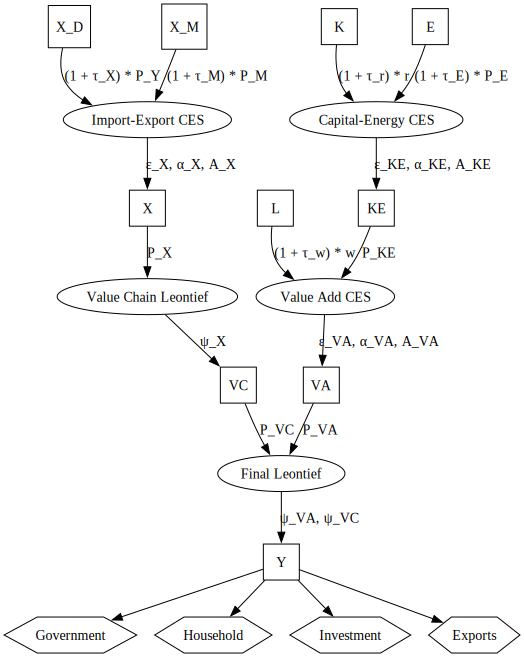

In [8]:
node_props = dict.fromkeys(
    ["VA", "VC", "X", "X_D", "X_M", "K", "E", "KE", "L", "Y"], {"shape": "square"}
)
node_props.update(
    dict.fromkeys(["Government", "Household", "Investment", "Exports"], {"shape": "hexagon"})
)

draw_graph(
    edge_list=[
        ("X_D", "Import-Export CES"),
        ("X_M", "Import-Export CES"),
        ("Import-Export CES", "X"),
        ("X", "Value Chain Leontief"),
        ("Value Chain Leontief", "VC"),
        ("K", "Capital-Energy CES"),
        ("E", "Capital-Energy CES"),
        ("Capital-Energy CES", "KE"),
        ("KE", "Value Add CES"),
        ("L", "Value Add CES"),
        ("Value Add CES", "VA"),
        ("VA", "Final Leontief"),
        ("VC", "Final Leontief"),
        ("Final Leontief", "Y"),
        ("Y", "Government"),
        ("Y", "Household"),
        ("Y", "Investment"),
        ("Y", "Exports"),
    ],
    node_props=node_props,
    edge_props={
        ("K", "Capital-Energy CES"): {"label": "(1 + τ_r) * r"},
        ("E", "Capital-Energy CES"): {"label": "(1 + τ_E) * P_E"},
        ("Capital-Energy CES", "KE"): {"label": "ε_KE, α_KE, A_KE"},
        ("X_D", "Import-Export CES"): {"label": "(1 + τ_X) * P_Y"},
        ("X_M", "Import-Export CES"): {"label": "(1 + τ_M) * P_M"},
        ("Import-Export CES", "X"): {"label": "ε_X, α_X, A_X"},
        ("KE", "Value Add CES"): {"label": "P_KE"},
        ("L", "Value Add CES"): {"label": "(1 + τ_w) * w"},
        ("Value Add CES", "VA"): {"label": "ε_VA, α_VA, A_VA"},
        ("X", "Value Chain Leontief"): {"label": "P_X"},
        ("Value Chain Leontief", "VC"): {"label": "ψ_X"},
        ("VA", "Final Leontief"): {"label": "P_VA"},
        ("VC", "Final Leontief"): {"label": "P_VC"},
        ("Final Leontief", "Y"): {"label": "ψ_VA, ψ_VC"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [9]:
final_firm_variables = [
    # Final Output
    Variable(name="Y", dims=("i"), description="Final output in the <dim:i> sector"),
    # Intermediate Outputs (4)
    Variable(
        name="X_bundled",
        dims=("i", "j"),
        description="Demand for bundle of import and domestic <dim:i> sector goods bundle by the <dim:j> sector as value-chain inputs",
    ),
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(
        name="KE",
        dims="i",
        description="Labor Capital demand in the <dim:i> sector",
    ),
    # Root inputs (5)
    # Variable(
    #     name="X",  # Called X_D and X_M on the graph above
    #     dims=("s", "i", "j"),
    #     description="Demand for <dim:s> <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    # ),
    Variable(
        name="X_D",
        dims=("i", "j"),
        description="Demand for domestic <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="X_M",
        dims=("i", "j"),
        description="Demand for imported <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demand in the <dim:i> sector",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="E_d",
        dims="i",
        extend_subscript=True,
        description="Energy demand in the <dim:i> sector",
    ),
    ## Prices (9)
    # Root factors (3)
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(
        name="P_E",
        extend_subscript=True,
        description="Price of electricity",
    ),
    # Intermediate Outputs (4)
    Variable(
        name="P_X",
        dims=["i", "j"],
        extend_subscript=True,
        description="Price of sector <dim:i> Armington mix in sector <dim:j>",
    ),
    Variable(
        name="P_KE",
        dims="i",
        extend_subscript=True,
        description="Price of the capital-labor bundle in the <dim:i> sector",
    ),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    # Final Prices (2) [domestic + foreign]
    Variable(
        name="P_Y",
        dims=["i"],
        extend_subscript=True,
        description="Final good price in the <dim:i> sector",
    ),
    Variable(
        name="P_M",
        dims=["i"],
        extend_subscript=True,
        description="Price of imported final goods from the <dim:i> sector",
    ),
]

#### Parameters

In [10]:
final_firm_parameters = [
    # CES share parameters (3)
    Parameter(
        "alpha_KE",
        dims="i",
        extend_subscript=True,
        description="Share of capital in production of the <dim:i> producer capital labour bundle",
    ),
    Parameter(
        "alpha_VA",
        dims="i",
        extend_subscript=True,
        description="Share of capital in production of the <dim:i> sector value-add bundle",
    ),
    Parameter(
        "alpha_X",
        dims=("i", "j"),
        extend_subscript=True,
        description="Bias for domestic <dim:i> goods in <dim:j>",
    ),
    # CES TFP Parameters (3)
    Parameter("A_VA", dims="i", description="Total factor productivity of the <dim:i> sector"),
    Parameter(
        "A_KE",
        dims="i",
        extend_subscript=True,
        description="Total factor productivity of Capital-Energy Bundling in the <dim:i> sector",
    ),
    Parameter(
        "A_X",
        dims=["i", "j"],
        extend_subscript=True,
        description="Total factor productivity of bundling <dim:i> goods in <dim:j> sector",
    ),
    # CES Elasticity Parameters (3)
    Parameter(
        name="epsilon_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(
        name="epsilon_KE",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> producer KL bundle",
    ),
    Parameter(
        name="epsilon_X",
        extend_subscript=True,
        dims=["i", "j"],
        description="Elasticity between home and imported good varieties of <dim:i> goods in sector <dim:j>",
    ),
    # Leontief share parameters (3)
    Parameter(
        "psi_X",
        dims=("i", "j"),
        extend_subscript=True,
        description="Share of <dim:i> demanded as input to <dim:j> value chain bundle",
    ),
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    # Tax rates (5)
    Parameter(
        "tau_w", extend_subscript=True, dims="i", description="Payroll rax tate in <dim:i> sector"
    ),
    Parameter(
        "tau_r",
        extend_subscript=True,
        dims="i",
        description="Capital use tax tax rate in <dim:i> sector",
    ),
    Parameter(
        "tau_E",
        extend_subscript=True,
        dims="i",
        description="Electricity tax rate in <dim:i> sector",
    ),
    # Parameter(
    #     "tau_X",
    #     extend_subscript=True,
    #     dims=("s", "i", "j"),
    #     description="VAT tax paid by <dim:j> on <dim:s> <dim:i> sector inputs",
    # ),
    Parameter(
        "tau_X_D",
        extend_subscript=True,
        dims=("i", "j"),
        description="VAT tax paid by <dim:j> on domestic <dim:i> sector inputs",
    ),
    Parameter(
        "tau_X_M",
        extend_subscript=True,
        dims=("i", "j"),
        description="VAT tax paid by <dim:j> on imported <dim:i> sector inputs",
    ),
    Parameter(
        "tau_Y", extend_subscript=True, dims=("i",), description="Output tax paid my <dim:i>"
    ),
    Parameter(
        name="tau_M",
        dims=("i",),
        extend_subscript=True,
        description="Import duty on consumption goods",
    ),
]

#### Equations

In [11]:
capital_energy_bundle = CES(
    factors=["K_d", "E_d"],
    factor_prices=["(1 + tau_r) * r", "(1 + tau_E) * P_E"],
    output="KE",
    output_price="P_KE",
    TFP="A_KE",
    factor_shares="alpha_KE",
    epsilon="epsilon_KE",
    backend=BACKEND,
)

value_add_bundle = CES(
    factors=["KE", "L_d"],
    factor_prices=["P_KE", "(1 + tau_w) * w"],
    output="VA",
    output_price="P_VA",
    TFP="A_VA",
    factor_shares="alpha_VA",
    epsilon="epsilon_VA",
    backend=BACKEND,
)

import_domestic_bundle = CES(
    # factors=["X[0]", "X[1]"],
    factors=["X_D", "X_M"],
    # factor_prices=[
    #     "(1 + tau_X[0]) * P_Y[:, None]",
    #     "(1 + tau_X[1]) * P_M[:, None]",
    # ],
    factor_prices=[
        "(1 + tau_X_D) * P_Y",
        "(1 + tau_X_M) * P_M",
    ],
    output="X_bundled",
    output_price="P_X",
    TFP="A_X",
    factor_shares="alpha_X",
    epsilon="epsilon_X",
    dims=["i", "j"],
    backend=BACKEND,
    expand_price_dim="input" if BACKEND == "pytensor" else None,
)

value_chain_bundle = leontief(
    factors="X_bundled",
    factor_prices="P_X",
    factor_shares="psi_X",
    output="VC",
    output_price="P_VC",
    dims=["i", "j"],
    sum_dim="i",
    coords=coords,
    expand_price_dim=False,
    backend=BACKEND,
)

final_goods = leontief(
    factors=["VC", "VA"],
    factor_prices=["P_VC", "P_VA"],
    factor_shares=["psi_VC", "psi_VA"],
    output="Y",
    output_price="(1 - tau_Y) * P_Y",
    dims="i",
    coords=coords,
    backend=BACKEND,
)

In [12]:
final_firm_equations = [
    # Value chain bundle
    Equation(
        "Sector <dim:j> production of intermediate goods bundle",
        value_chain_bundle[0],
    ),
    Equation(
        "Sector <dim:j> demand for sector <dim:i> intermediate input",
        value_chain_bundle[1],
    ),
    # Armington Bundle
    Equation(
        "Sector <dim:j> production of <dim:i> import-domestic bundle", import_domestic_bundle[0]
    ),
    Equation("Sector <dim:i> demand for domestic <dim:j> inputs", import_domestic_bundle[1]),
    Equation("Sector <dim:i> demand for imported <dim:j> inputs", import_domestic_bundle[2]),
    # Capital Labour aggregation
    Equation("Producer <dim:i> production of capital-energy bundle", capital_energy_bundle[0]),
    Equation("Producer <dim:i> demand for captial", capital_energy_bundle[1]),
    Equation("Producer <dim:i> demand for energy", capital_energy_bundle[2]),
    # Value add bundle
    Equation("Sector <dim:i> production of value add", value_add_bundle[0]),
    Equation("Sector <dim:i> demand for capital energy bundle", value_add_bundle[1]),
    Equation("Sector <dim:i> demand for labour", value_add_bundle[2]),
    # Sector Final Goods
    Equation("Final good production of sector <dim:i>", final_goods[0]),
    Equation("Sector <dim:i> demand for intermediate goods bundle", final_goods[1]),
    Equation("Sector <dim:i> demand for value added", final_goods[2]),
]

##### Test Equations

In [13]:
if BACKEND == "pytensor":
    pt_vars, pt_params, cache = convert_to_pt(final_firm_variables, final_firm_parameters, coords)
    test_equations(final_firm_variables, final_firm_parameters, final_firm_equations, coords)

Found 19 variables; unrolled count 75
Found 19 parameters; unrolled count 93
Found 14 equations; unrolled count 66
Output shapes: [(3,), (3, 3), (3, 3), (3, 3), (3, 3), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,)]


## Producers of Energy

### Structure

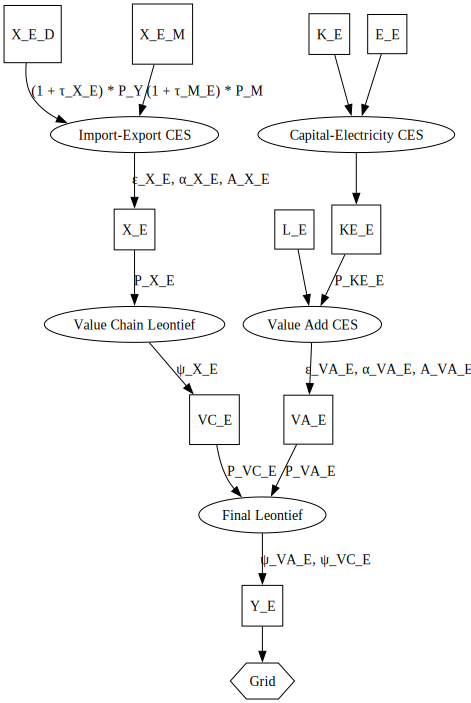

In [14]:
node_props = dict.fromkeys(
    ["VA_E", "VC_E", "X_E", "X_E_D", "X_E_M", "K_E", "E_E", "KE_E", "L_E", "Y_E"],
    {"shape": "square"},
)
node_props.update(dict.fromkeys(["Grid"], {"shape": "hexagon"}))

draw_graph(
    edge_list=[
        ("X_E_D", "Import-Export CES"),
        ("X_E_M", "Import-Export CES"),
        ("Import-Export CES", "X_E"),
        ("X_E", "Value Chain Leontief"),
        ("Value Chain Leontief", "VC_E"),
        ("K_E", "Capital-Electricity CES"),
        ("E_E", "Capital-Electricity CES"),
        ("Capital-Electricity CES", "KE_E"),
        ("KE_E", "Value Add CES"),
        ("L_E", "Value Add CES"),
        ("Value Add CES", "VA_E"),
        ("VA_E", "Final Leontief"),
        ("VC_E", "Final Leontief"),
        ("Final Leontief", "Y_E"),
        ("Y_E", "Grid"),
    ],
    node_props=node_props,
    edge_props={
        ("K_E", "Capital-Labor CES"): {"label": "(1 + τ_r_E) * r"},
        ("L_E", "Capital-Labor CES"): {"label": "(1 + τ_w_E) * w"},
        ("Capital-Labor CES", "KE_E"): {"label": "ε_KE_E, α_KE_E, A_KE_E"},
        ("X_E_D", "Import-Export CES"): {"label": "(1 + τ_X_E) * P_Y"},
        ("X_E_M", "Import-Export CES"): {"label": "(1 + τ_M_E) * P_M"},
        ("Import-Export CES", "X_E"): {"label": "ε_X_E, α_X_E, A_X_E"},
        ("KE_E", "Value Add CES"): {"label": "P_KE_E"},
        ("E_E", "Value Add CES"): {"label": "(1 - τ_E_E) * P_E"},
        ("Value Add CES", "VA_E"): {"label": "ε_VA_E, α_VA_E, A_VA_E"},
        ("X_E", "Value Chain Leontief"): {"label": "P_X_E"},
        ("Value Chain Leontief", "VC_E"): {"label": "ψ_X_E"},
        ("VA_E", "Final Leontief"): {"label": "P_VA_E"},
        ("VC_E", "Final Leontief"): {"label": "P_VC_E"},
        ("Final Leontief", "Y_E"): {"label": "ψ_VA_E, ψ_VC_E"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [15]:
energy_firm_variables = [
    # Top-level output (1)
    Variable(
        name="Y_E",
        dims=("k",),
        extend_subscript=True,
        description="Final output in the <dim:k> energy sector",
    ),
    # Intermediate outputs (4)
    Variable(
        name="VC_E",
        dims="k",
        extend_subscript=True,
        description="Value-chain component of <dim:k> energy producer",
    ),
    Variable(
        name="VA_E",
        dims="k",
        extend_subscript=True,
        description="Value-added component of <dim:k> sector production",
    ),
    Variable(
        name="X_bundled_E",
        dims=("i", "k"),
        extend_subscript=1,
        description="Demand for bundle of import and domestic <dim:i> sector goods bundle by the <dim:k> sector as value-chain inputs",
    ),
    Variable(
        name="KE_E",
        dims="k",
        extend_subscript=True,
        description="Capital-Electricity bundle demanded in the <dim:k> sector",
    ),
    # Root inputs (5)
    # Variable(
    #     name="X_E",
    #     dims=("s", "i", "k"),
    #     extend_subscript=True,
    #     description="Demand for <dim:s> <dim:i> sector goods by the <dim:k> sector",
    # ),
    Variable(
        name="X_E_D",
        dims=("i", "k"),
        extend_subscript=2,
        description="Demand for domestic <dim:i> sector goods by the <dim:k> sector",
    ),
    Variable(
        name="X_E_M",
        dims=("i", "k"),
        extend_subscript=2,
        description="Demand for imported <dim:i> sector goods by the <dim:k> sector",
    ),
    Variable(
        name="L_E_d",
        dims="k",
        extend_subscript=2,
        description="Labor demand in the <dim:k> e-sector",
    ),
    Variable(
        name="K_E_d",
        dims="k",
        extend_subscript=2,
        description="Capital demand in the <dim:k> e-sector",
    ),
    Variable(
        name="E_E_d",
        dims="k",
        extend_subscript=2,
        description="Electricity demand by <dim:k> sector",
    ),
    ## Prices
    # Final output
    Variable(
        name="P_Y_E",
        dims=("k",),
        extend_subscript=2,
        description="Price of energy output by <dim:k> sector",
    ),
    # Intermediate outputs (4)
    Variable(
        name="P_KE_E",
        dims="k",
        extend_subscript=2,
        description="Price of capital-electricity bundle formed by <dim:k> sector",
    ),
    Variable(
        name="P_VA_E",
        dims="k",
        extend_subscript=2,
        description="Price of value-add bundle in <dim:k> sector",
    ),
    Variable(
        name="P_X_E",
        dims=["i", "k"],
        extend_subscript=2,
        description="Price of <dim:i> Armington bundle formed by <dim:k> sector",
    ),
    Variable(
        name="P_VC_E",
        dims="k",
        extend_subscript=2,
        description="Price of value chain bundle in <dim:k> sector",
    ),
]

#### Parameters

In [16]:
energy_firm_parameters = [
    # CES share parameters (3)
    Parameter(
        "alpha_KE_E",
        dims="k",
        extend_subscript=2,
        description="Share of capital in <dim:k> sector capital-electricity bundle",
    ),
    Parameter(
        "alpha_VA_E",
        dims="k",
        extend_subscript=2,
        description="Share of capital-electricity in production of <dim:k> sector value-add",
    ),
    Parameter(
        "alpha_X_E",
        dims=["i", "k"],
        extend_subscript=2,
        description="Home bias for <dim:i> goods in the <dim:k> sector",
    ),
    # CES TFP parameters (3)
    Parameter(
        "A_KE_E",
        dims="k",
        extend_subscript=2,
        description="Captial-electricity factor productivity of <dim:k> producer",
    ),
    Parameter("A_VA_E", dims="k", description="Total factor productivity of the <dim:k> sector"),
    Parameter(
        "A_X_E",
        dims=["i", "k"],
        extend_subscript=2,
        description="Total factor productivity bundling <dim:i> goods in the <dim:k> sector ",
    ),
    # CES elasticity parameters (3)
    Parameter(
        name="epsilon_KE_E",
        extend_subscript=2,
        dims="k",
        description="Elasticity of subsitution between capital and electricity in <dim:k>",
    ),
    Parameter(
        name="epsilon_VA_E",
        extend_subscript=2,
        dims="k",
        description="Elasticity of subsitution between VA and VC in <dim:k>",
    ),
    Parameter(
        name="epsilon_X_E",
        dims=["i", "k"],
        extend_subscript=2,
        description="Elesticity of substitution between domestic and imported <dim:i> varieties in <dim:k>",
    ),
    # Leontief share parameters (3)
    Parameter(
        "psi_X_E",
        extend_subscript=2,
        dims=("i", "k"),
        description="Share of <dim:i> sector final goods in the <dim:k> value chain bundle",
    ),
    Parameter(
        "psi_VC_E",
        extend_subscript=2,
        dims="k",
        description="Share of value chain bundle in <dim:k> sector final good production",
    ),
    Parameter(
        "psi_VA_E",
        extend_subscript=2,
        dims="k",
        description="Share of value add bundle in <dim:k> sector final good production",
    ),
    # Tax rates (5)
    Parameter(
        "tau_w_E", extend_subscript=2, dims="k", description="Payroll rax tate in <dim:k> sector"
    ),
    Parameter(
        "tau_r_E",
        extend_subscript=2,
        dims="k",
        description="Capital use tax rate in <dim:k> sector",
    ),
    Parameter(
        "tau_E_E",
        extend_subscript=2,
        dims="k",
        description="Electricity tax rate in <dim:k> sector",
    ),
    # Parameter(
    #     "tau_X_E",
    #     extend_subscript=2,
    #     dims=("s", "i", "k"),
    #     description="VAT tax paid by <dim:k> sector on <dim:i> inputs",
    # ),
    Parameter(
        "tau_X_E_D",
        extend_subscript=3,
        dims=("i", "k"),
        description="VAT tax paid by <dim:k> sector on domestic <dim:i> inputs",
    ),
    Parameter(
        "tau_X_E_M",
        extend_subscript=3,
        dims=("i", "k"),
        description="VAT tax paid by <dim:k> sector on imported <dim:i> inputs",
    ),
    Parameter(
        "tau_Y_E",
        extend_subscript=2,
        dims=("k",),
        description="Output tax paid by <dim:k> sector",
    ),
]

#### Equations

In [17]:
capital_electricity_bundle = CES(
    factors=["K_E_d", "E_E_d"],
    factor_prices=["(1 + tau_r_E) * r", "(1 + tau_E_E) * P_E"],
    output="KE_E",
    output_price="P_KE_E",
    TFP="A_KE_E",
    factor_shares="alpha_KE_E",
    epsilon="epsilon_KE_E",
    backend=BACKEND,
)

value_add_bundle = CES(
    factors=["KE_E", "L_E_d"],
    factor_prices=["P_KE_E", "(1 + tau_w_E) * w"],
    output="VA_E",
    output_price="P_VA_E",
    TFP="A_VA_E",
    factor_shares="alpha_VA_E",
    epsilon="epsilon_VA_E",
    backend=BACKEND,
)

import_domestic_bundle = CES(
    # factors=["X_E[0]", "X_E[1]"],
    # factor_prices=[
    #     "(1 + tau_X_E[0]) * P_Y[:, None]",
    #     "(1 + tau_X_E[1]) * P_M[:, None]",
    # ],
    factors=["X_E_D", "X_E_M"],
    factor_prices=["(1 + tau_X_E_D) * P_Y", "(1 + tau_X_E_M) * P_M"],
    output="X_bundled_E",
    output_price="P_X_E",
    TFP="A_X_E",
    factor_shares="alpha_X_E",
    epsilon="epsilon_X_E",
    dims=["i", "k"],
    backend=BACKEND,
    expand_price_dim="input" if BACKEND == "pytensor" else None,
)

value_chain_bundle = leontief(
    factors="X_bundled_E",
    factor_prices="P_X_E",
    factor_shares="psi_X_E",
    output="VC_E",
    output_price="P_VC_E",
    dims=["i", "k"],
    sum_dim="i",
    expand_price_dim=False,
    coords=coords,
    transpose_output=False,
    backend=BACKEND,
)

final_goods = leontief(
    factors=["VC_E", "VA_E"],
    factor_prices=["P_VC_E", "P_VA_E"],
    factor_shares=["psi_VC_E", "psi_VA_E"],
    output="Y_E",
    output_price="((1 - tau_Y_E) * P_Y_E)",
    dims="k",
    coords=coords,
    backend=BACKEND,
)

In [19]:
energy_firm_equations = [
    # Value chain bundle
    Equation(
        "Sector <dim:k> production of intermediate goods bundle",
        value_chain_bundle[0],
    ),
    Equation(
        "Sector <dim:k> demand for sector <dim:i> intermediate input",
        value_chain_bundle[1],
    ),
    # Armington Bundle
    Equation(
        "Sector <dim:k> production of <dim:i> import-domestic bundle", import_domestic_bundle[0]
    ),
    Equation("Sector <dim:k> demand for domestic <dim:i> inputs", import_domestic_bundle[1]),
    Equation("Sector <dim:k> demand for imported <dim:i> inputs", import_domestic_bundle[2]),
    # Capital Labour aggregation
    Equation(
        "Producer <dim:k> production of capital-electricity bundle", capital_electricity_bundle[0]
    ),
    Equation("Producer <dim:k> demand for captial", capital_electricity_bundle[1]),
    Equation("Producer <dim:k> demand for electricity", capital_electricity_bundle[2]),
    # Value add bundle
    Equation("Sector <dim:k> production of value add", value_add_bundle[0]),
    Equation("Sector <dim:k> demand for capital-electricity bundle", value_add_bundle[1]),
    Equation("Sector <dim:k> demand for labor", value_add_bundle[2]),
    # Sector Final Goods
    Equation("Final good production of sector <dim:k>", final_goods[0]),
    Equation("Sector <dim:k> demand for intermediate goods bundle", final_goods[1]),
    Equation("Sector <dim:k> demand for value added", final_goods[2]),
]

In [20]:
if BACKEND == "pytensor":
    pt_vars, pt_params, cache = convert_to_pt(
        energy_firm_variables, energy_firm_parameters, coords, cache, allow_overwrite=True
    )
    test_equations(
        energy_firm_variables, energy_firm_parameters, energy_firm_equations, coords, cache=cache
    )

Found 15 variables; unrolled count 207
Found 18 parameters; unrolled count 270
Found 14 equations; unrolled count 198
Output shapes: [(9,), (3, 9), (3, 9), (3, 9), (3, 9), (9,), (9,), (9,), (9,), (9,), (9,), (9,), (9,), (9,)]


## Electricity Producer (Grid)

### Structure

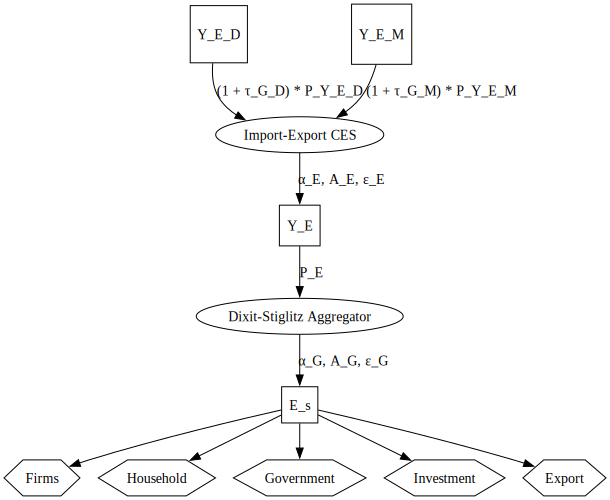

In [21]:
node_props = dict.fromkeys(["Y_E_D", "Y_E_M", "Y_E", "E_s"], {"shape": "square"})
node_props.update(
    dict.fromkeys(
        ["Firms", "Household", "Government", "Investment", "Export"], {"shape": "hexagon"}
    )
)

draw_graph(
    edge_list=[
        ("Y_E_D", "Import-Export CES"),
        ("Y_E_M", "Import-Export CES"),
        ("Import-Export CES", "Y_E"),
        ("Y_E", "Dixit-Stiglitz Aggregator"),
        ("Dixit-Stiglitz Aggregator", "E_s"),
        ("E_s", "Firms"),
        ("E_s", "Household"),
        ("E_s", "Government"),
        ("E_s", "Investment"),
        ("E_s", "Export"),
    ],
    node_props=node_props,
    edge_props={
        ("Y_E_D", "Import-Export CES"): {"label": "(1 + τ_G_D) * P_Y_E_D"},
        ("Y_E_M", "Import-Export CES"): {"label": "(1 + τ_G_M) * P_Y_E_M"},
        ("Import-Export CES", "Y_E"): {"label": "α_E, A_E, ε_E"},
        ("Y_E", "Dixit-Stiglitz Aggregator"): {"label": "P_E"},
        ("Dixit-Stiglitz Aggregator", "E_s"): {"label": "α_G, A_G, ε_G"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [22]:
grid_variables = [
    # Final Output
    Variable(name="E_s", description="Total electricity supplied by the grid"),
    # Intermediate Output
    Variable(
        "Y_bundled_E",
        dims="k",
        extend_subscript=1,
        description="Import-export bundle for energy produced by <dim:k> sector",
    ),
    # Inputs
    # Variable(
    #     name="Y_E_d",
    #     dims=("s", "k"),
    #     extend_subscript=True,
    #     description="<dim:s> grid demand for energy produced by <dim:k> sector",
    # ),
    Variable(
        name="Y_E_D_d",
        dims=("k"),
        extend_subscript=4,
        description="Domestic grid demand for energy produced by <dim:k> sector",
    ),
    Variable(
        name="Y_E_M_d",
        dims=("k"),
        extend_subscript=4,
        description="Imported grid demand for energy produced by <dim:k> sector",
    ),
    # Intermediate Price
    Variable(
        name="P_bundled_Y_E",
        dims="k",
        extend_subscript=2,
        description="Price of import-export for <dim:k> energy formed by the grid",
    ),
    # World price of power input
    Variable(
        name="P_M_E",
        dims=("k",),
        extend_subscript=True,
        description="Price of <dim:k> energy imports",
    ),
]

#### Parameters

In [23]:
grid_parameters = [
    # CES Parameters (3)
    Parameter(
        name="alpha_GM",
        dims=["k"],
        extend_subscript=True,
        description="Grid home bias for <dim:k> energy purchases",
    ),
    Parameter(
        name="A_GM",
        dims=["k"],
        extend_subscript=True,
        description="Total factor productivity of import-export bundling for <dim:k> energy purchases",
    ),
    Parameter(
        name="epsilon_GM",
        dims=["k"],
        extend_subscript=True,
        description="Elasticity of substitution between domestic and imported <dim:k> energy varieties",
    ),
    # DX Parameters (3)
    Parameter(
        name="alpha_G",
        dims="k",
        extend_subscript=True,
        description="Share of <dim:k> energy in the production of electricity",
    ),
    Parameter(name="A_G", description="Total factor productivity of grid electricity production"),
    Parameter(
        name="epsilon_G",
        description="Elasticity of subsitution between energy varieties in grid production",
    ),
    # Taxes
    # Parameter(
    #     name="tau_G",
    #     dims=("s", "k"),
    #     extend_subscript=True,
    #     description="Sales tax on <dim:k> energy purchases by the grid",
    # ),
    Parameter(
        name="tau_G_D",
        dims=("k"),
        extend_subscript=2,
        description="Sales tax on domestic <dim:k> energy purchases by the grid",
    ),
    Parameter(
        name="tau_G_M",
        dims=("k"),
        extend_subscript=2,
        description="Sales tax on imported <dim:k> energy purchases by the grid",
    ),
    Parameter(
        name="tau_M_E",
        dims=("k",),
        extend_subscript=True,
        description="Import duty on energy goods",
    ),
]

#### Equations

In [24]:
import_domestic_bundle = CES(
    factors=["Y_E_D_d", "Y_E_M_d"],
    factor_prices=["(1 + tau_G_D) * P_Y_E", "(1 + tau_G_M) * P_M_E"],
    output="Y_bundled_E",
    output_price="P_bundled_Y_E",
    TFP="A_GM",
    factor_shares="alpha_GM",
    epsilon="epsilon_GM",
    dims=("k",),
    backend=BACKEND,
)

electricity_production = dixit_stiglitz(
    factors="Y_bundled_E",
    factor_prices="P_bundled_Y_E",
    output="E_s",
    output_price="P_E",
    TFP="A_G",
    factor_shares="alpha_G",
    epsilon="epsilon_G",
    dims="k",
    coords=coords,
    backend=BACKEND,
)

In [25]:
grid_equations = [
    # Armington Bundle
    Equation("Grid production of <dim:k> import-domestic bundle", import_domestic_bundle[0]),
    Equation("Grid demand for domestic <dim:k> energy", import_domestic_bundle[1]),
    Equation("Grid demand for imported <dim:k> energy", import_domestic_bundle[2]),
    # Production of electricity
    Equation("Grid production of electricity", electricity_production[0]),
    Equation("Grid demand for <dim:k> energy", electricity_production[1]),
]

In [26]:
if BACKEND == "pytensor":
    *_, cache = convert_to_pt(grid_variables, grid_parameters, coords, cache, allow_overwrite=False)
    test_equations(grid_variables, grid_parameters, grid_equations, coords, cache)

Found 6 variables; unrolled count 46
Found 9 parameters; unrolled count 65
Found 5 equations; unrolled count 37
Output shapes: [(9,), (9,), (9,), (), (9,)]


## Household

### Structure

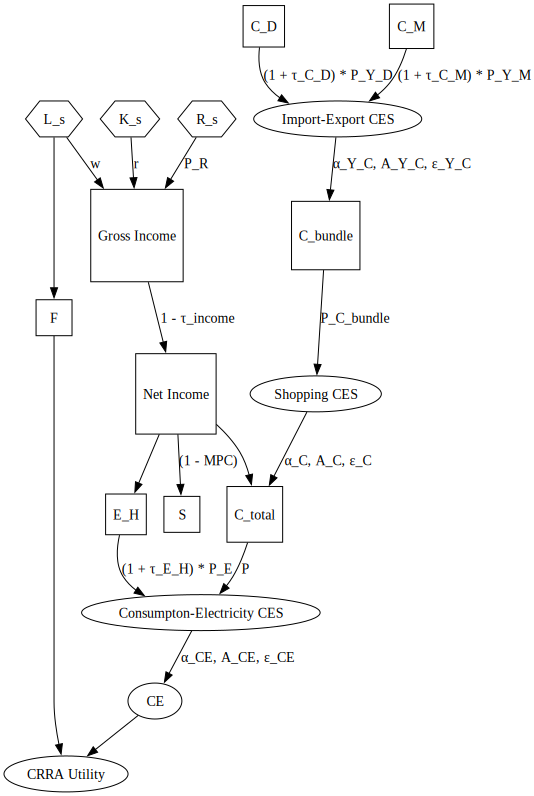

In [27]:
node_props = dict.fromkeys(
    ["C_D", "C_M", "E_H", "L_s", "F", "S", "C_bundle", "C_total", "Gross Income", "Net Income"],
    {"shape": "square"},
)
node_props.update(dict.fromkeys(["K_s", "R_s", "L_s"], {"shape": "hexagon"}))

draw_graph(
    edge_list=[
        ("C_D", "Import-Export CES"),
        ("C_M", "Import-Export CES"),
        ("Import-Export CES", "C_bundle"),
        ("C_bundle", "Shopping CES"),
        ("Shopping CES", "C_total"),
        ("C_total", "Consumpton-Electricity CES"),
        ("E_H", "Consumpton-Electricity CES"),
        ("Consumpton-Electricity CES", "CE"),
        ("L_s", "F"),
        ("F", "CRRA Utility"),
        ("CE", "CRRA Utility"),
        ("L_s", "Gross Income"),
        ("K_s", "Gross Income"),
        ("R_s", "Gross Income"),
        ("Gross Income", "Net Income"),
        ("Net Income", "C_total"),
        ("Net Income", "S"),
        ("Net Income", "E_H"),
    ],
    node_props=node_props,
    edge_props={
        ("C_D", "Import-Export CES"): {"label": "(1 + τ_C_D) * P_Y_D"},
        ("C_M", "Import-Export CES"): {"label": "(1 + τ_C_M) * P_Y_M"},
        ("Import-Export CES", "C_bundle"): {"label": "α_Y_C, A_Y_C, ε_Y_C"},
        ("C_bundle", "Shopping CES"): {"label": "P_C_bundle"},
        ("Shopping CES", "C_total"): {"label": "α_C, A_C, ε_C"},
        ("L_s", "Gross Income"): {"label": "w"},
        ("K_s", "Gross Income"): {"label": "r"},
        ("R_s", "Gross Income"): {"label": "P_R"},
        ("Net Income", "S"): {"label": "(1 - MPC)"},
        ("Gross Income", "Net Income"): {"label": "1 - τ_income"},
        ("E_H", "Consumpton-Electricity CES"): {"label": "(1 + τ_E_H) * P_E"},
        ("C_total", "Consumpton-Electricity CES"): {"label": "P"},
        ("Consumpton-Electricity CES", "CE"): {"label": "α_CE, A_CE, ε_CE"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [28]:
household_variables = [
    # Inputs to shopping
    Variable(
        name="C_D",  # Called C_M and C_D above
        dims=("i"),
        description="Household demand for domestic <dim:i> goods",
    ),
    Variable(
        name="C_M",  # Called C_M and C_D above
        dims=("i"),
        description="Household demand for imported <dim:i> goods",
    ),
    Variable(
        name="C_bundled",
        dims="i",
        description="Sector <dim:i> import-domestic bundle formed by households",
    ),
    # Inputs to final consumption basket
    Variable(name="E_H_d", extend_subscript=True, description="Household demand for electricity"),
    Variable(
        name="C_total", latex_name=r"\bar{C}", description="Household final consumption bundle"
    ),
    # Spending variables
    Variable(name="F", description="Household leisure time"),
    Variable(name="S", description="Household savings"),
    Variable(name="CE", description="Consumption-Electricity bundle"),
    # Income definitions
    Variable(name="L_s", description="Household supply of labor"),
    Variable(
        name="income",  # Gross Income above
        latex_name="Omega",
        description="Household income, before taxes",
    ),
    Variable(
        name="net_income", latex_name=r"\hat{\Omega}", description="Household income, after taxes"
    ),
    # Prices
    Variable(
        name="P_bundled_C",
        dims="i",
        extend_subscript=1,
        description="Price of the import-domestic bundle for <dim:i> goods",
    ),
    Variable(name="P", description="Core consumer price index, excluding energy"),
    Variable(name="P_CE", description="Consumer Price Index", extend_subscript=True),
    # Utility
    Variable(name="U", description="Household utility"),
]

#### Parameters

In [29]:
household_parameters = [
    # Factor endowments
    Parameter(name="T", description="Time endowment"),
    Parameter(name="K_s", description="Capital stock"),
    # Armington Parameters
    Parameter(
        name="alpha_C_M", dims=("i",), description="Household home bias in for <dim:i> goods"
    ),
    Parameter(
        name="A_C_M",
        dims=("i",),
        description="Household total factor productivity bundling domestic and imported <dim:i> goods",
    ),
    Parameter(
        name="epsilon_C_M",
        dims=("i",),
        description="Household elasticity of substitution between domestic and imported <dim:i> goods",
    ),
    # Shopping CES parameters
    Parameter(
        name="alpha_C",
        dims="i",
        description="Household elasticity of consumption utility for <dim:i> sector goods",
    ),
    Parameter(name="A_C", description="Household total factor productivity of shopping"),
    Parameter(
        name="epsilon_C",
        description="Elasticity of substitution between varieties in final consumption basket",
    ),
    # Electricity-Consumption bundling parameters
    Parameter(
        name="alpha_CE",
        description="Share of consumption in final spending",
    ),
    Parameter(name="A_CE", description="Household total factor productivity of final bundling"),
    Parameter(
        name="epsilon_CE",
        description="Elasticity of substitution between consumption and electricity",
    ),
    # Utility Parameters
    Parameter(
        name="sigma_C",
        description="Arrow-Pratt risk averson",
    ),
    Parameter(name="sigma_L", description="Inverse Frisch elasticity between work and leisure"),
    Parameter(name="Theta", description="Household labor dispreference parameter"),
    # Miscellaneous
    Parameter(name="mpc", latex_name="phi", description="Household marginal propensity to consume"),
    # Latent price influences
    Parameter(
        name="P_C_D_bar",
        dims=["i"],
        description="Unobserved shifter of domestic <dim:i> good prices facing households",
    ),
    Parameter(
        name="P_C_M_bar",
        dims=["i"],
        description="Unobserved shifter of imported <dim:i> good prices facing households",
    ),
    Parameter(
        name="P_E_H_bar", description="Unobserved shfiter of electricity prices facing households"
    ),
    # Taxes
    Parameter(
        name="tau_C_D",
        dims=["i"],
        description="Sales tax paid by households for domestic <dim:i> goods",
    ),
    Parameter(
        name="tau_C_M",
        dims=["i"],
        description="Sales tax paid by households for imported <dim:i> goods",
    ),
    Parameter(name="tau_E_H", description="Sales tax paid by households for electricity"),
    Parameter(name="tau_w_income", description="Income tax from wages paid by households"),
    Parameter(name="tau_r_income", description="Income tax from capital paid by households"),
]

#### Equations

In [30]:
import_domestic_bundle = CES(
    factors=["C_D", "C_M"],
    factor_prices=[
        "((1 + tau_C_D) * (P_Y + P_C_D_bar))",
        "((1 + tau_C_M) * (P_M + P_C_M_bar))",
    ],
    output="C_bundled",
    output_price="P_bundled_C",
    TFP="A_C_M",
    factor_shares="alpha_C_M",
    epsilon="epsilon_C_M",
    dims=("i",),
    backend=BACKEND,
)

shopping_function = dixit_stiglitz(
    factors="C_bundled",
    factor_prices="P_bundled_C",
    output="C_total",
    output_price="P",
    TFP="A_C",
    factor_shares="alpha_C",
    epsilon="epsilon_C",
    dims="i",
    coords=coords,
    backend=BACKEND,
)

consumption_electricity_bundle = CES(
    factors=["C_total", "E_H_d"],
    factor_prices=["P", "((1 + tau_E_H) * (P_E + P_E_H_bar))"],
    output="CE",
    output_price="P_CE",
    TFP="A_CE",
    factor_shares="alpha_CE",
    epsilon="epsilon_CE",
    backend=BACKEND,
)

In [31]:
household_equations = [
    # Import-Domestic Bundling
    Equation("Household production of <dim:i> import-domestic bundle", import_domestic_bundle[0]),
    Equation("Household demand for domestic <dim:i> goods", import_domestic_bundle[1]),
    Equation("Household demand for imported <dim:i> goods", import_domestic_bundle[2]),
    # Production of consumption basket (shopping)
    Equation("Final consumption bundle", shopping_function[0]),
    Equation("Household demand for <dim:i> goods", shopping_function[1]),
    # # Basket-Electricity bundle
    Equation("Goods-Electricity bundle", consumption_electricity_bundle[0]),
    Equation("Household demand for goods basket", consumption_electricity_bundle[1]),
    Equation("Household demand for electricity", consumption_electricity_bundle[2]),
    # Income
    Equation(
        "Household pre-tax income",
        "income = w * L_s + r * K_s",
    ),
    Equation(
        "Household after-tax income",
        "net_income = (1 - tau_w_income) * w * L_s + (1 - tau_r_income) * r * K_s",
    ),
    Equation("Household budget constraint", "CE * P_CE = mpc * net_income"),
    Equation(
        "Household utility",
        "U = CE ** (1 - sigma_C) / (1 - sigma_C) + F ** (1 - sigma_L) / (1 - sigma_L)",
    ),
    Equation("Household supply of labor", "F ** -sigma_L / CE ** -sigma_C = w / P_CE / Theta"),
    Equation("Household savings", "S = (1 - mpc) * net_income"),
]

In [32]:
if BACKEND == "pytensor":
    *_, cache = convert_to_pt(
        household_variables, household_parameters, coords, cache, allow_overwrite=True
    )
    test_equations(household_variables, household_parameters, household_equations, coords, cache)

Found 15 variables; unrolled count 23
Found 23 parameters; unrolled count 39
Found 14 equations; unrolled count 22
Output shapes: [(3,), (3,), (3,), (), (3,), (), (), (), (), (), (), (), (), ()]


## Investment

### Structure

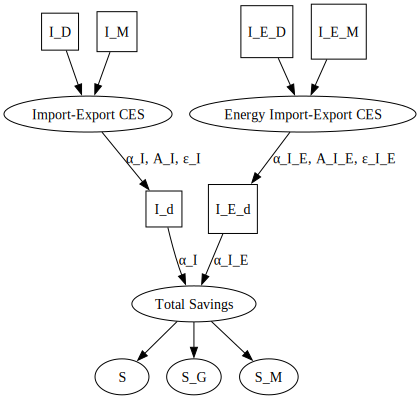

In [33]:
node_props = dict.fromkeys(["I_D", "I_M", "I_E_D", "I_E_M", "I_d", "I_E_d"], {"shape": "square"})


draw_graph(
    edge_list=[
        ("I_D", "Import-Export CES"),
        ("I_M", "Import-Export CES"),
        ("Import-Export CES", "I_d"),
        ("I_E_D", "Energy Import-Export CES"),
        ("I_E_M", "Energy Import-Export CES"),
        ("Energy Import-Export CES", "I_E_d"),
        ("I_d", "Total Savings"),
        ("I_E_d", "Total Savings"),
        ("Total Savings", "S"),
        ("Total Savings", "S_G"),
        ("Total Savings", "S_M"),
    ],
    node_props=node_props,
    edge_props={
        ("I_d", "Total Savings"): {"label": "α_I"},
        ("I_E_d", "Total Savings"): {"label": "α_I_E"},
        ("Import-Export CES", "I_d"): {"label": "α_I, A_I, ε_I"},
        ("Energy Import-Export CES", "I_E_d"): {"label": "α_I_E, A_I_E, ε_I_E"},
    },
    # edge_props={
    #     ("I_D", "Import-Export CES"): {"label": "(1 + τ_I_D) * P_Y_D"},
    #     ("I_M", "Import-Export CES"): {"label": "(1 + τ_I_M) * P_Y_M"},
    # },
    graph_direction="UD",
)

### Implementation

#### Variables

In [34]:
investment_variables = [
    Variable(name="I_s", description="Total supply of capital"),
    Variable(
        name="I_D_d",
        dims=("i"),
        extend_subscript=True,
        description="Demand for domestic investment capital by the <dim:i> sector",
    ),
    Variable(
        name="I_M_d",
        dims=("i"),
        extend_subscript=True,
        description="Demand for imported investment capital by the <dim:i> sector",
    ),
    Variable(
        name="I_bundle",
        dims="i",
        description="Armington bundle for investment goods by <dim:i> sector",
    ),
    Variable(
        name="P_I",
        dims="i",
        extend_subscript=True,
        description="Price of Armington investment bundle in <dim:i> sector",
    ),
    Variable(
        name="I_E_D_d",
        dims=("k"),
        extend_subscript=True,
        description="Demand for domestic investment capital by the <dim:k> sector",
    ),
    Variable(
        name="I_E_M_d",
        dims=("k"),
        extend_subscript=True,
        description="Demand for imported investment capital by the <dim:k> sector",
    ),
    Variable(
        name="I_bundle_E",
        dims="k",
        extend_subscript=1,
        description="Armington bundle for investment goods by <dim:k> sector",
    ),
    Variable(
        name="P_I_E",
        dims="k",
        extend_subscript=True,
        description="Price of Armington investment bundle in <dim:k> sector",
    ),
]

#### Parameters

In [35]:
investment_parameters = [
    Parameter("S_G", description="Supply of government investment capital"),
    Parameter("S_M", description="Supply of international investment capital"),
    Parameter(
        name="alpha_I_M",
        dims=("i",),
        description="Sector <dim:i> bias for domestic investment goods",
    ),
    Parameter(
        name="A_I_M",
        dims=("i",),
        extend_subscript=True,
        description="Sector <dim:i> TFP in combining import and domestic investment goods",
    ),
    Parameter(
        name="epsilon_I_M",
        dims=("i",),
        extend_subscript=True,
        description="<dim:i> elasticity of substitution between foreign and domestic investment goods",
    ),
    Parameter(
        name="alpha_I_E_M",
        dims=("k",),
        extend_subscript=True,
        description="Sector <dim:k> bias for domestic investment goods",
    ),
    Parameter(
        name="A_I_E_M",
        dims=("k",),
        extend_subscript=True,
        description="Sector <dim:k> TFP in combining import and domestic investment goods",
    ),
    Parameter(
        name="epsilon_I_E_M",
        dims=("k",),
        extend_subscript=True,
        description="<dim:k> elasticity of substitution between foreign and domestic investment goods",
    ),
    Parameter("alpha_I", dims="i", description="<dim:i> share of total investment"),
    Parameter("alpha_I_E", dims="k", description="<dim:k> share of total investment"),
    Parameter("tau_I_D", dims=("i"), description="Tax on domestic capital in sector <dim:i>"),
    Parameter("tau_I_M", dims=("i"), description="Tax on imported capital in sector <dim:i>"),
    Parameter(
        "tau_I_E_D", dims=("k"), description="Tax on domestic capital investment in sector <dim:k>"
    ),
    Parameter(
        "tau_I_E_M", dims=("k"), description="Tax on imported capital investment in sector <dim:k>"
    ),
]

#### Equations

In [36]:
import_domestic_bundle = CES(
    factors=["I_D_d", "I_M_d"],
    factor_prices=["(1 + tau_I_D) * P_Y", "(1 + tau_I_M) * P_M"],
    output="I_bundle",
    output_price="P_I",
    TFP="A_I_M",
    factor_shares="alpha_I_M",
    epsilon="epsilon_I_M",
    dims="i",
    backend=BACKEND,
)

energy_import_domestic_bundle = CES(
    factors=["I_E_D_d", "I_E_M_d"],
    factor_prices=["(1 + tau_I_E_D) * P_Y_E", "(1 + tau_I_E_M) * P_M_E"],
    output="I_bundle_E",
    output_price="P_I_E",
    TFP="A_I_E_M",
    factor_shares="alpha_I_E_M",
    epsilon="epsilon_I_E_M",
    dims="i",
    backend=BACKEND,
)

In [37]:
investment_equations = [
    Equation("<dim:i> sector demand for domestic-import capital bundle", import_domestic_bundle[0]),
    Equation("<dim:i> sector demand for domestic capital", import_domestic_bundle[1]),
    Equation("<dim:i> sector demand for imported capital", import_domestic_bundle[2]),
    Equation(
        "<dim:k> sector demand for domestic-import capital bundle", energy_import_domestic_bundle[0]
    ),
    Equation("<dim:k> sector demand for domestic capital", energy_import_domestic_bundle[1]),
    Equation("<dim:k> sector demand for imported capital", energy_import_domestic_bundle[2]),
    Equation("<dim:i> sector demand for capital", "P_I * I_bundle = alpha_I * I_s"),
    Equation("<dim:k> sector demand for capital", "P_I_E * I_bundle_E = alpha_I_E * I_s"),
]

In [38]:
if BACKEND == "pytensor":
    *_, cache = convert_to_pt(
        investment_variables, investment_parameters, coords, cache, allow_overwrite=True
    )
    test_equations(investment_variables, investment_parameters, investment_equations, coords, cache)

Found 9 variables; unrolled count 49
Found 14 parameters; unrolled count 74
Found 8 equations; unrolled count 48
Output shapes: [(3,), (3,), (3,), (9,), (9,), (9,), (3,), (9,)]


## International Trade

### Implementation

#### Variables

In [39]:
trade_parameters = [
    Parameter(name="M", dims="i", description="Supply of imports from <dim:i> sector"),
    Parameter(name="Ex", dims="i", description="Supply of exports from <dim:i> sector"),
    Parameter(
        name="M_E",
        dims="k",
        extend_subscript=1,
        description="Supply of energy imports from <dim:k> sector",
    ),
    Parameter(
        name="Ex_E",
        dims="k",
        extend_subscript=1,
        description="Supply of energy exports from <dim:k> sector",
    ),
    # Parameter(
    #     name="P_W", dims="i", extend_subscript=1, description="World price of <dim:i> sector goods"
    # ),
    # Parameter(
    #     name="P_W_E",
    #     dims="k",
    #     extend_subscript=1,
    #     description="World price of <dim:k> sector goods",
    # ),
]

In [40]:
trade_variables = [Variable(name="P_Ex"), Variable(name="P_Ex_M")]

#### Equations


## Government

### Structure

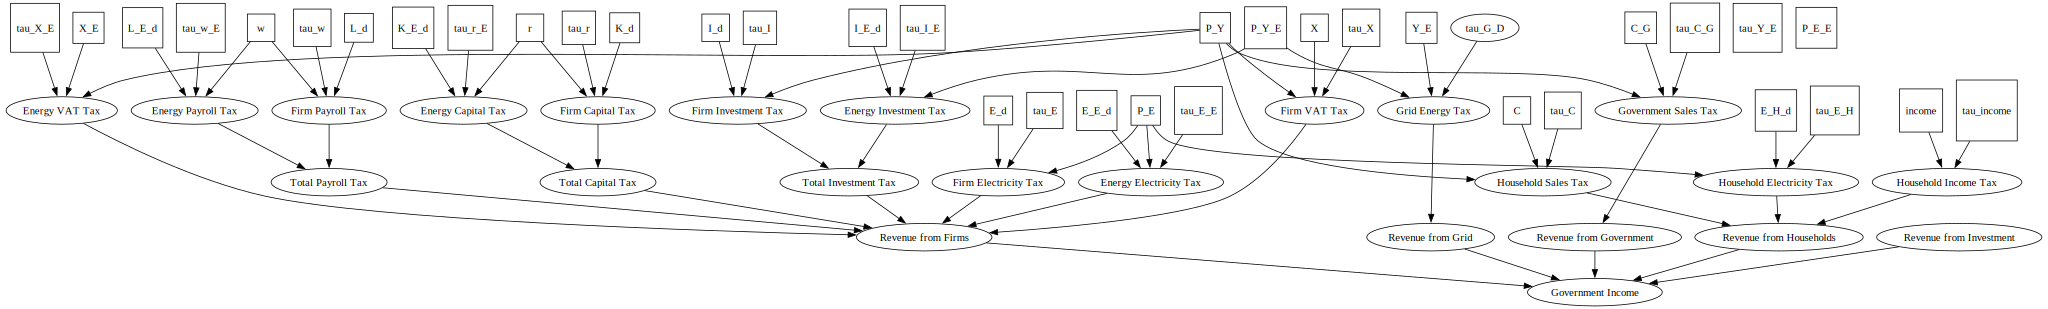

In [41]:
all_taxes = [
    "tau_w",
    "tau_w_E",
    "tau_r",
    "tau_r_E",
    "tau_E",
    "tau_E_H",
    "tau_X",
    "tau_X_E",
    "tau_C",
    "tau_C_G",
    "tau_I",
    "tau_I_E",
    "tau_Y_E",
    "tau_E_E",
    "tau_income",
]
taxed_prices = ["P_Y", "w", "r", "P_Y_E", "P_E", "P_E_E"]

taxed_quantities = [
    "L_d",
    "L_E_d",
    "K_d",
    "K_E_d",
    "E_d",
    "E_H_d",
    "X",
    "X_E",
    "E_E_d",
    "I_d",
    "I_E_d",
    "income",
    "Y_E",
    "C_G",
    "C",
]

node_props = dict.fromkeys(all_taxes + taxed_prices + taxed_quantities, {"shape": "square"})

draw_graph(
    edge_list=[
        ("L_d", "Firm Payroll Tax"),
        ("w", "Firm Payroll Tax"),
        ("tau_w", "Firm Payroll Tax"),
        ("L_E_d", "Energy Payroll Tax"),
        ("tau_w_E", "Energy Payroll Tax"),
        ("w", "Energy Payroll Tax"),
        ("K_d", "Firm Capital Tax"),
        ("r", "Firm Capital Tax"),
        ("tau_r", "Firm Capital Tax"),
        ("K_E_d", "Energy Capital Tax"),
        ("tau_r_E", "Energy Capital Tax"),
        ("r", "Energy Capital Tax"),
        ("X", "Firm VAT Tax"),
        ("P_Y", "Firm VAT Tax"),
        ("tau_X", "Firm VAT Tax"),
        ("E_d", "Firm Electricity Tax"),
        ("P_E", "Firm Electricity Tax"),
        ("tau_E", "Firm Electricity Tax"),
        ("E_E_d", "Energy Electricity Tax"),
        ("P_E", "Energy Electricity Tax"),
        ("tau_E_E", "Energy Electricity Tax"),
        ("X_E", "Energy VAT Tax"),
        ("tau_X_E", "Energy VAT Tax"),
        ("P_Y", "Energy VAT Tax"),
        ("Y_E", "Grid Energy Tax"),
        ("P_Y_E", "Grid Energy Tax"),
        ("tau_G_D", "Grid Energy Tax"),
        ("I_d", "Firm Investment Tax"),
        ("P_Y", "Firm Investment Tax"),
        ("tau_I", "Firm Investment Tax"),
        ("I_E_d", "Energy Investment Tax"),
        ("P_Y_E", "Energy Investment Tax"),
        ("tau_I_E", "Energy Investment Tax"),
        ("C_G", "Government Sales Tax"),
        ("P_Y", "Government Sales Tax"),
        ("tau_C_G", "Government Sales Tax"),
        ("C", "Household Sales Tax"),
        ("P_Y", "Household Sales Tax"),
        ("tau_C", "Household Sales Tax"),
        ("E_H_d", "Household Electricity Tax"),
        ("P_E", "Household Electricity Tax"),
        ("tau_E_H", "Household Electricity Tax"),
        ("income", "Household Income Tax"),
        ("tau_income", "Household Income Tax"),
        ("Firm Payroll Tax", "Total Payroll Tax"),
        ("Energy Payroll Tax", "Total Payroll Tax"),
        ("Total Payroll Tax", "Revenue from Firms"),
        ("Firm Capital Tax", "Total Capital Tax"),
        ("Energy Capital Tax", "Total Capital Tax"),
        ("Total Capital Tax", "Revenue from Firms"),
        ("Firm Investment Tax", "Total Investment Tax"),
        ("Energy Investment Tax", "Total Investment Tax"),
        ("Total Investment Tax", "Revenue from Firms"),
        ("Firm VAT Tax", "Revenue from Firms"),
        ("Energy VAT Tax", "Revenue from Firms"),
        ("Firm Electricity Tax", "Revenue from Firms"),
        ("Energy Electricity Tax", "Revenue from Firms"),
        ("Grid Energy Tax", "Revenue from Grid"),
        ("Government Sales Tax", "Revenue from Government"),
        ("Household Electricity Tax", "Revenue from Households"),
        ("Household Sales Tax", "Revenue from Households"),
        ("Household Income Tax", "Revenue from Households"),
        ("Revenue from Grid", "Government Income"),
        ("Revenue from Firms", "Government Income"),
        ("Revenue from Investment", "Government Income"),
        ("Revenue from Government", "Government Income"),
        ("Revenue from Households", "Government Income"),
    ],
    node_props=node_props,
    edge_props={},
    graph_direction="UD",
)

### Implementation

#### Variables

In [42]:
government_variables = [
    Variable(name="G", description="Government budget"),
    Variable(
        name="C_G_D",
        dims=("i"),
        extend_subscript=True,
        description="Government consumption of domestic <dim:i> goods",
    ),
    Variable(
        name="C_G_M",
        dims=("i"),
        extend_subscript=True,
        description="Government consumption of imported <dim:i> goods",
    ),
    Variable(
        name="C_bundled_G",
        dims=("i",),
        extend_subscript=1,
        description="Government <dim:i> domestic-imported bundle",
    ),
    Variable(
        name="P_C_G",
        dims=("i",),
        extend_subscript=True,
        description="Price of government domestic-import bundle for <dim:i> sector goods",
    ),
]

#### Parameters

In [43]:
government_parameteres = [
    Parameter(
        "alpha_Gov",
        dims="i",
        extend_subscript=True,
        description="Share of <dim:i> sector final goods in governmnet consumption",
    ),
    Parameter(
        name="alpha_C_G",
        dims=("i",),
        extend_subscript=True,
        description="Government home bias in for <dim:i> goods",
    ),
    Parameter(
        name="A_C_G",
        dims=("i",),
        extend_subscript=True,
        description="Government total factor productivity bundling domestic and imported <dim:i> goods",
    ),
    Parameter(
        name="epsilon_C_G",
        dims=("i",),
        extend_subscript=True,
        description="Government elasticity of substitution between domestic and imported <dim:i> goods",
    ),
    Parameter(
        name="tau_C_G_D",
        dims=("i",),
        extend_subscript=True,
        description="Tax rate paid by government for domestic sector <dim:i> goods",
    ),
    Parameter(
        name="tau_C_G_M",
        dims=("i",),
        extend_subscript=True,
        description="Tax rate paid by government for imported sector <dim:i> goods",
    ),
    Parameter(
        name="tau_Ex",
        dims="i",
        extend_subscript=True,
        description="Export duty paid by <dim:i> firm to ship goods abroad",
    ),
    Parameter(
        name="tau_Ex_E",
        dims="k",
        extend_subscript=2,
        description="Export duty paid by <dim:k> firm to ship goods abroad",
    ),
]

#### Equations

In [44]:
import_domestic_bundle = CES(
    factors=["C_G_D", "C_G_M"],
    factor_prices=["(1 + tau_C_G_D) * P_Y", "(1 + tau_C_G_M) * P_M"],
    output="C_bundled_G",
    output_price="P_C_G",
    TFP="A_C_G",
    factor_shares="alpha_C_G",
    epsilon="epsilon_C_G",
    dims="i",
    backend=BACKEND,
)

In [45]:
def _sum_reduce(eq, dims, coords, backend, axis=None):
    if backend == "pytensor":
        return f"({eq}).sum(axis={axis})"
    elif backend == "numba":
        if isinstance(dims, str):
            dims = [dims]
        for dim in dims:
            n = len(coords[dim]) - 1
            eq = f"Sum({eq}, ({dim}, 0, {n}))"
        return eq


from functools import partial

sum_reduce = partial(_sum_reduce, coords=coords, backend=BACKEND)

In [46]:
s = "[:, None]" if BACKEND == "pytensor" else ""
government_equations = [
    Equation(
        "Government budget constraint",
        "G + S_G = "
        + "+".join(
            [
                # Firm taxes
                sum_reduce(f"(tau_X_D * P_Y{s} * X_D)", ["i", "j"]),  # Firm domestic VAT
                sum_reduce(f"(tau_X_M * P_M{s} * X_M)", ["i", "j"]),  # Firm import VAT
                sum_reduce("(tau_w * L_d * w)", "i"),  # Firm payroll tax
                sum_reduce("(tau_r * K_d * r)", "i"),  # Firm capital use tax
                sum_reduce("(tau_E * E_d * P_E)", "i"),  # Firm electricity
                sum_reduce("(tau_Y * P_Y * Y)", "i"),  # Firm output tax
                # # Energy producer taxes
                sum_reduce(
                    f"(tau_X_E_D * P_Y{s} * X_E_D)", ["i", "k"], axis=1
                ),  # Energy domestic VAT
                sum_reduce(
                    f"(tau_X_E_M * P_M{s} * X_E_M)", ["i", "k"], axis=1
                ),  # Energy import VAT
                sum_reduce("(tau_w_E * L_E_d * w)", "k"),  # Energy payroll tax
                sum_reduce("(tau_r_E * K_E_d * r)", "k"),  # Energy capital use tax
                sum_reduce("(tau_E_E * E_E_d * P_E)", "k"),  # Energy electricity use tax
                sum_reduce("(tau_Y_E * P_Y_E * Y_E)", "k"),  # Firm output tax
                # # Grid
                sum_reduce(
                    "(tau_G_D * Y_E_D_d * P_Y_E)", "k"
                ),  # Energy domestic inputs to electricity production
                sum_reduce(
                    "(tau_G_M * Y_E_M_d * P_M_E)", "k"
                ),  # Energy imported inputs to electricity production
                # # Investment
                sum_reduce("(tau_I_D * I_D_d * P_Y)", "i"),  # Tax on domestic capital investment
                sum_reduce("(tau_I_M * I_M_d * P_M)", "i"),  # Tax on imported capital investment
                sum_reduce(
                    "(tau_I_E_D * I_E_D_d * P_Y_E)", "k"
                ),  # Tax on domestic energy capital investment
                sum_reduce(
                    "(tau_I_E_M * I_E_M_d * P_M_E)", "k"
                ),  # Tax on imported energy capital investment
                # # Household
                sum_reduce("(tau_C_D * P_Y * C_D)", "i"),  # Consumption
                sum_reduce("(tau_C_M * P_M * C_M)", "i"),  # Consumption
                "(tau_E_H * E_H_d * P_E)",  # Household electricity
                "(tau_w_income * w * L_s)",  # Income tax (direct tax)
                "(tau_r_income * r * K_s)",  # Income tax (direct tax)
                # Government
                sum_reduce("(tau_C_G_D * P_Y * C_G_D)", "i"),  # Government consumption
                sum_reduce("(tau_C_G_M * P_M * C_G_M)", "i"),  # Government consumption
                # Export duties
                sum_reduce("(tau_Ex * P_Y * Ex)", "i"),  # Tax on consumption exports
                sum_reduce("(tau_Ex_E * P_Y_E * Ex_E)", "k"),  # Tax on energy exports
                # Import duties
                sum_reduce("(tau_M * P_M * M)", "i"),  # Tax on consumption exports
                sum_reduce("(tau_M_E * P_M_E * M_E)", "k"),  # Tax on energy export
            ]
        ),
    ),
    Equation(
        "Government demand for <dim:i> sector domestic-import goods", import_domestic_bundle[0]
    ),
    Equation("Government demand for domestic <dim:i> sector goods", import_domestic_bundle[1]),
    Equation("Government demand for imported <dim:i> sector goods", import_domestic_bundle[2]),
    Equation("Government consumption of <dim:i> sector goods", "C_bundled_G = alpha_Gov * G"),
]

In [48]:
if BACKEND == "pytensor":
    *_, cache = convert_to_pt(
        government_variables,
        government_parameteres + trade_parameters,
        coords,
        cache,
        allow_overwrite=True,
    )
    test_equations(
        government_variables,
        government_parameteres + trade_parameters,
        government_equations,
        coords,
        cache,
    )

Found 5 variables; unrolled count 13
Found 12 parameters; unrolled count 54
Found 5 equations; unrolled count 15
Output shapes: [(3,), (3,), (3,), (3,), (3,)]


## Market Clearing

### Structure

### Implementation

#### Variables

In [49]:
clearing_variables = [Variable("resid", description="Walrasian residual")]

#### Parameters

In [50]:
# Exogenous values
clearing_parameters = [
    Parameter("P_num", latex_name=r"\\bar{P}_{num}", description="Numeraire price"),
]

#### Equations

In [51]:
clearing_equations = [
    # Factor markets
    Equation(
        "Labour market clearing",
        "L_s = " + "+".join([sum_reduce("L_d", "i"), sum_reduce("L_E_d", "k")]),
    ),
    Equation(
        "Capital market clearing",
        "K_s = " + "+".join([sum_reduce("K_d", "i"), sum_reduce("K_E_d", "k")]),
    ),
    Equation(
        "Electricity market clearing",
        "E_s = " + "+".join([sum_reduce("E_d", "i"), sum_reduce("E_E_d", "k"), "E_H_d"]),
    ),
    # Investment market
    Equation("Domestic investment market clearing", "I_s = S + S_G + S_M + resid"),
    # Goods markets
    Equation("<dim:k> domestic energy market clearing", "Y_E = Y_E_D_d + (1 - tau_Ex_E) * Ex_E"),
    Equation("<dim:k> import energy market clearing", "M_E = Y_E_M_d"),
    Equation(
        "Sector <dim:i> domestic goods market clearing",
        f"Y = C_D + C_G_D + I_D_d + {sum_reduce('X_D', 'j', axis=1)} + {sum_reduce('X_E_D', 'k', axis=1)} + (1 - tau_Ex) * Ex",
    ),
    Equation(
        "Sector <dim:i> import goods market clearing",
        f"M = C_M + C_G_M + I_M_d + {sum_reduce('X_M', 'j', axis=1)} + {sum_reduce('X_E_M', 'k', axis=1)}",
    ),
    # Misc.
    Equation("Total time constraint", "T = L_s + F"),
    Equation("Numeraire", "w = P_num"),
]

In [52]:
if BACKEND == "pytensor":
    *_, cache = convert_to_pt(
        clearing_variables, clearing_parameters, coords, cache, allow_overwrite=True
    )
    test_equations(clearing_variables, clearing_parameters, clearing_equations, coords, cache)

Found 1 variables; unrolled count 1
Found 1 parameters; unrolled count 1
Found 10 equations; unrolled count 30
Output shapes: [(), (), (), (), (9,), (9,), (3,), (3,), (), ()]


# Check for Squareness

In [53]:
all_parameters = (
    final_firm_parameters
    + energy_firm_parameters
    + grid_parameters
    + household_parameters
    + investment_parameters
    + government_parameteres
    + trade_parameters
    + clearing_parameters
)
all_variables = (
    final_firm_variables
    + energy_firm_variables
    + grid_variables
    + household_variables
    + investment_variables
    + government_variables
    + clearing_variables
)
all_equations = (
    final_firm_equations
    + energy_firm_equations
    + grid_equations
    + household_equations
    + investment_equations
    + government_equations
    + clearing_equations
)

if BACKEND == "pytensor":
    pt_vars, pt_params, cache = convert_to_pt(all_variables, all_parameters, coords)
    pt_eqs = convert_equations(all_equations, coords, cache)

    n_variables, n_eqs, n_params = [
        int(sum([np.prod(x.type.shape) for x in pt_objs]))
        for pt_objs in [pt_vars, pt_eqs, pt_params]
    ]
    if n_variables != n_eqs:
        raise ValueError(
            f"System is not square, found {n_eqs} equations but {n_variables} variables"
        )
    print(f"Final system has {n_eqs} equations and variables, and {n_params} parameters")

ValueError: System is not square, found 416 equations but 414 variables

In [55]:
for x in sorted(pt_vars, key=lambda x: x.name):
    print(x.name)

CE
C_D
C_G_D
C_G_M
C_M
C_bundled
C_bundled_G
C_total
E_E_d
E_H_d
E_d
E_s
F
G
I_D_d
I_E_D_d
I_E_M_d
I_M_d
I_bundle
I_bundle_E
I_s
KE
KE_E
K_E_d
K_d
L_E_d
L_d
L_s
P
P_CE
P_C_G
P_E
P_I
P_I_E
P_KE
P_KE_E
P_M
P_M_E
P_VA
P_VA_E
P_VC
P_VC_E
P_X
P_X_E
P_Y
P_Y_E
P_bundled_C
P_bundled_Y_E
S
U
VA
VA_E
VC
VC_E
X_D
X_E_D
X_E_M
X_M
X_bundled
X_bundled_E
Y
Y_E
Y_E_D_d
Y_E_M_d
Y_bundled_E
income
net_income
r
resid
w
